In [8]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os
from backtester.log import Log

from collections import defaultdict


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


def get_time_part(df: pd.DataFrame, l, h) -> pd.DataFrame:
    dfret = df.copy()
    dfret = dfret[(dfret["timestamp"] >= l) & (dfret["timestamp"] < h)].reset_index(drop=True)
    return dfret

In [9]:
CROISSANTS = "CROISSANTS"
DJEMBES = "DJEMBES"
JAMS = "JAMS"
KELP = "KELP"
PICNIC_BASKET1 = "PICNIC_BASKET1"
PICNIC_BASKET2 = "PICNIC_BASKET2"
RAINFOREST_RESIN = "RAINFOREST_RESIN"
SQUID_INK = "SQUID_INK"
VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"

market_data_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_2.csv"), sep=";")
market_data_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_3.csv"), sep=";")
market_data_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_4.csv"), sep=";")

trades_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_2.csv"), sep=";")
trades_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_3.csv"), sep=";")
trades_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_4.csv"), sep=";")

observations_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_2.csv"), sep=",")
observations_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_3.csv"), sep=",")
observations_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_4.csv"), sep=",")

market_data_round_5_all3days = concatenate_historical_data([market_data_round_5_day_2, market_data_round_5_day_3, market_data_round_5_day_4])
trades_round_5_all3days = concatenate_historical_data([trades_round_5_day_2, trades_round_5_day_3, trades_round_5_day_4])
observations_round_5_all3days = concatenate_historical_data([observations_round_5_day_2, observations_round_5_day_3, observations_round_5_day_4])

round4finallog = Log.from_file("round4final.log")


In [10]:
md = market_data_round_5_day_4.copy()
th = trades_round_5_day_4.copy()
obs = observations_round_5_day_4.copy()

In [11]:
import numpy as np
import pandas as pd


def get_lagged_correlation(series1: pd.Series, series2: pd.Series, lag1: int = 0, lead1: int = 0, lag2: int = 0, lead2: int = 0) -> float:
    """
    Compute correlation between log returns of two time series with optional lags/leads.
    Positive lag = look back; Positive lead = look forward.
    """
    if lag1 > 0:
        ret1 = np.log(series1) - np.log(series1).shift(lag1)
    elif lead1 > 0:
        ret1 = np.log(series1).shift(-lead1) - np.log(series1)
    else:
        ret1 = np.log(series1).diff()

    if lag2 > 0:
        ret2 = np.log(series2) - np.log(series2).shift(lag2)
    elif lead2 > 0:
        ret2 = np.log(series2).shift(-lead2) - np.log(series2)
    else:
        ret2 = np.log(series2).diff()

    # Align and drop NaNs
    aligned = pd.DataFrame({"series1": ret1, "series2": ret2}).dropna()
    if aligned.empty:
        return np.nan

    return np.corrcoef(aligned["series1"], aligned["series2"])[0, 1]


croissants = md[md["product"] == CROISSANTS]['ask_price_1'].reset_index(drop=True)
picnic_basket1 = md[md["product"] == PICNIC_BASKET1]['ask_price_1'].reset_index(drop=True)

corrs = {}
for croissants_lag in range(1, 20, 1):
    for picnic_basket1_lead in range(1, 20, 1):
        corrs[croissants_lag, picnic_basket1_lead] = get_lagged_correlation(croissants, picnic_basket1, lag1=croissants_lag, lead2=picnic_basket1_lead)


print(sorted(corrs.items(), reverse=True, key = lambda x: abs(x[1])))

[((6, 6), 0.05665281937789897), ((6, 5), 0.05525011929562405), ((5, 6), 0.054866251240567404), ((7, 6), 0.05461468458565917), ((6, 7), 0.05423809025036195), ((7, 5), 0.054188299934921386), ((8, 5), 0.05399791464447008), ((8, 6), 0.05391910315198605), ((5, 7), 0.0534590875538705), ((8, 4), 0.053402999692799456), ((6, 8), 0.05291755926973744), ((6, 4), 0.052891352419711594), ((5, 8), 0.052620712840870124), ((5, 5), 0.052568152181869686), ((7, 4), 0.05243748861508305), ((7, 7), 0.05200300623012769), ((4, 6), 0.0517915666884116), ((4, 8), 0.051492202349482936), ((9, 5), 0.05145248900614816), ((9, 4), 0.051185573554165094), ((4, 7), 0.051036385798853064), ((9, 6), 0.05057813454066273), ((8, 7), 0.05051938043977565), ((17, 17), -0.050408883950333), ((17, 16), -0.0500194565583121), ((16, 17), -0.04996111021062086), ((7, 8), 0.049923969087570824), ((18, 18), -0.0498278938682108), ((18, 17), -0.04974580511312813), ((5, 4), 0.04973713150130109), ((5, 9), 0.049710551345971604), ((17, 18), -0.0496

In [13]:
import pandas as pd
import numpy as np

from sklearn.ensemble      import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics        import r2_score

# 1) REBUILD YOUR DATAFRAME FRESH:
data = pd.DataFrame({
    "pb1":        md[md["product"] == PICNIC_BASKET1]["mid_price"].reset_index(drop=True),
    "croissants": md[md["product"] == CROISSANTS]["mid_price"].reset_index(drop=True),
    "djembes":    md[md["product"] == DJEMBES]["mid_price"].reset_index(drop=True),
    "jams":       md[md["product"] == JAMS]["mid_price"].reset_index(drop=True),
})

# 2) LOG RETURNS
ret_cols = []
for col in data.columns:
    r = f"{col}_ret"
    data[r] = np.log(data[col] / data[col].shift(1))
    ret_cols.append(r)

# 3) ROLLING VOLATILITIES (20‑period STD of returns)
vol_cols = []
window = 20
for r in ret_cols:
    v = f"{r}_vol"
    data[v] = data[r].rolling(window).std()
    vol_cols.append(v)

# 4) MOMENTUM (5‑period rolling mean of returns)
mom_cols = []
mom_window = 5
for r in ret_cols:
    m = f"{r}_mom{mom_window}"
    data[m] = data[r].rolling(mom_window).mean()
    mom_cols.append(m)

# 5) LAG FEATURES
max_ret_lag = 5
max_vol_lag = 3
max_mom_lag = 3

#   a) lagged returns
for r in ret_cols:
    for lag in range(1, max_ret_lag+1):
        data[f"{r}_lag{lag}"] = data[r].shift(lag)

#   b) lagged vols
for v in vol_cols:
    for lag in range(1, max_vol_lag+1):
        data[f"{v}_lag{lag}"] = data[v].shift(lag)

#   c) lagged momenta
for m in mom_cols:
    for lag in range(1, max_mom_lag+1):
        data[f"{m}_lag{lag}"] = data[m].shift(lag)

# 6) TARGET = next‑step pb1 return
data["y"] = data["pb1_ret"].shift(-1)

# 7) CLEAN UP any rows with NaNs
data.dropna(inplace=True)

# 8) ASSEMBLE YOUR FEATURES
feature_cols = []

# all ret lags
feature_cols += [f"{r}_lag{lag}" for r in ret_cols for lag in range(1, max_ret_lag+1)]
# all vol lags
feature_cols += [f"{v}_lag{lag}" for v in vol_cols for lag in range(1, max_vol_lag+1)]
# all mom lags
feature_cols += [f"{m}_lag{lag}" for m in mom_cols for lag in range(1, max_mom_lag+1)]

X = data[feature_cols]
y = data["y"]

# 9) TRAIN/TEST SPLIT (time‑ordered)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 10) RANDOM FOREST + TIME‑SERIES CV
tscv = TimeSeriesSplit(n_splits=5)
param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth":    [  3,   5,  10, None],
    "min_samples_split": [2, 5, 10],
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_dist,
    n_iter=20,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    random_state=42,
)
search.fit(X_train, y_train)

best_rf = search.best_estimator_
y_pred = best_rf.predict(X_test)

print("🔍 Best RF params:", search.best_params_)
print(f"✔️ Out‑of‑sample R² = {r2_score(y_test, y_pred):.4f}")

# 11) OPTIONAL: TOP 10 FEATURE IMPORTANCES
importances = pd.Series(best_rf.feature_importances_, index=feature_cols)
print("\nTop 10 features by importance:")
print(importances.sort_values(ascending=False).head(10))


🔍 Best RF params: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 3}
✔️ Out‑of‑sample R² = -0.0015

Top 10 features by importance:
djembes_ret_mom5_lag1      0.064245
djembes_ret_lag3           0.059670
pb1_ret_lag4               0.047820
pb1_ret_mom5_lag2          0.044307
djembes_ret_lag4           0.042306
croissants_ret_vol_lag2    0.039007
jams_ret_vol_lag3          0.037950
pb1_ret_mom5_lag1          0.037796
croissants_ret_vol_lag1    0.036944
pb1_ret_lag5               0.034546
dtype: float64


ValueError: x and y must be the same size

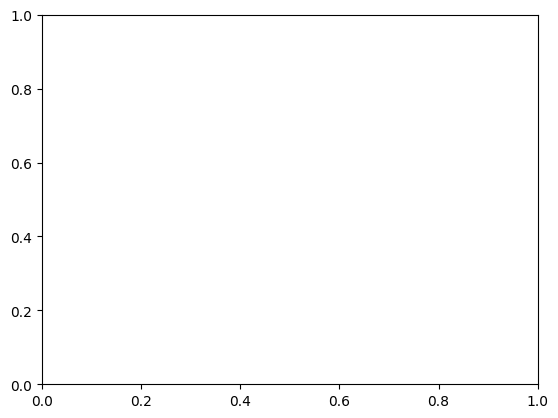

In [ ]:
sunlight = obs['sunlightIndex'].reset_index(drop=True)
spread = data['pb1'] - 6 * data['croissants'] - 3 *data['jams'] - 1* data['djembes']


plt.scatter(sunlight, spread)
plt.show()
np.corrcoef(sunlight, spread)